<a href="https://colab.research.google.com/github/JakeOh/202007_itw_bd18/blob/master/lab_ml/ml10_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 앙상블 학습 방법(Ensemble Learning)

* 앙상블(ensemble): 기계 학습에서 사용되는 일련의 모델(알고리즘)들.
    * 서로 다른 모델(알고리즘) 여러개를 훈련시키는 방법.
    * 같은 모델(알고리즘)을 서로 다른 훈련 셋에서 훈련시키는 방법.
* 앙상블 학습: 앙상블을 사용한 기계 학습 방법.
    * 투표(voting) 방식: 서로 다른 알고리즘들을 학습시켜서, 각각의 예측값을 투표(다수결) 또는 평균으로 예측하는 방법.
    * Bagging(Bootstrap Aggregating): **중복을 허용해서 샘플링**한 훈련 셋의 부분집합들을 하나의 알고리즘에 학습시켜서 예측(다수결, 평균).
    * Pasting: **중복을 허용하지 않고 샘플링**한 훈련 셋의 부분집합들을 하나의 알고리즘에 학습시켜서 예측.
    * Random Forest: Bagging 방법을 적용한 Decision Tree 앙상블 학습 방법.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons

In [2]:
X, y = make_moons(n_samples=500, noise=0.3, random_state=42)
X.shape, y.shape

((500, 2), (500,))

In [3]:
np.unique(y)

array([0, 1])

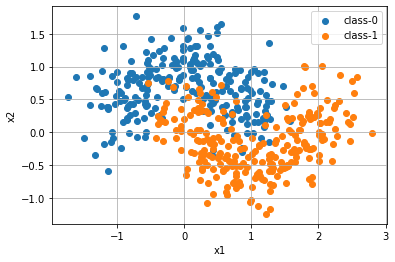

In [4]:
for cls in np.unique(y):
    plt.scatter(X[y == cls, 0], X[y == cls, 1], label=f'class-{cls}')
plt.legend()
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid()

In [5]:
# Train/Test 분리
from sklearn.model_selection import train_test_split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((400, 2), (100, 2), (400,), (100,))

* 약한 학습기(weak learner) 여러개를 훈련 셋(X_train, y_train)으로 훈련.
* 각 학습기에서 테스트 셋(X_test, y_test)의 예측값을 계산하고 평가.

In [7]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [8]:
# 학습기(learner) 4개 생성.
log_clf = LogisticRegression(random_state=42,)
sgd_clf = SGDClassifier(random_state=42, loss='log')
svm_clf = SVC(random_state=42, probability=True)
forest_clf = RandomForestClassifier(random_state=42, max_depth=3)

In [9]:
classifier = [log_clf, sgd_clf, svm_clf, forest_clf]
for clf in classifier:
    clf.fit(X_train, y_train)  # 모델을 훈련 셋으로 학습시킴.
    y_test_pred = clf.predict(X_test)  # 훈련된 모델로 테스트 셋의 예측값을 계산.
    acc = accuracy_score(y_test, y_test_pred)  # 예측값의 정확도 평가.
    print(clf.__class__.__name__, 'accuracry:', acc)

LogisticRegression accuracry: 0.85
SGDClassifier accuracry: 0.85
SVC accuracry: 0.87
RandomForestClassifier accuracry: 0.87


In [10]:
from sklearn.ensemble import VotingClassifier

* VotingClassifier의 voting 파라미터
    * 기본값='hard', 'soft'를 사용할 수 있음.
    * hard: 다수결 투표. 모든 분류기가 동일하게 1표씩 행사.
    * soft: 각 분류기의 예측값에 그 예측의 확률을 가중치로 곱한 값을 사용해서 예측. 확률이 높은 예측값이 더 높은 가중치를 가지고 투표를 하게되는 방식.
    * 일반적으로 soft voting 방식이 성능이 더 좋다고 알려져 있음.
    * soft voting을 사용하려면 모든 분류기가 예측 확률을 계산할 수 있어야 함!
        * SGDClassifier인 경우에는 loss='log'로 지정.
        * SVC인 경우에는 probability=True로 지정.

In [11]:
voting_clf = VotingClassifier(estimators=[('logistic', log_clf),
                                          ('sgd', sgd_clf),
                                          ('svc', svm_clf),
                                          ('rf', forest_clf)],
                              voting='soft',
                              n_jobs=-1)  # 모델 생성

In [12]:
voting_clf.fit(X_train, y_train)  # 모델 훈련

VotingClassifier(estimators=[('logistic',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('sgd',
                              SGDClassifier(alpha=0.0001, average=False,
                                            class_weight=None,
                                            early_st...
                                                     crit

In [13]:
y_test_pred = voting_clf.predict(X_test)  # 예측, 평가
acc = accuracy_score(y_test, y_test_pred)
print('voting ensemble accuracry:', acc)

voting ensemble accuracry: 0.86


## Bagging(Bootstrap Aggregating)

In [14]:
from sklearn.tree import DecisionTreeClassifier

In [15]:
# Decision Tree 분류기 1개를 훈련 셋 전체에 대해서 학습. -> 테스트 셋에서 평가.
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_test_pred = tree_clf.predict(X_test)
acc = accuracy_score(y_test, y_test_pred)
acc

0.82

In [16]:
from sklearn.ensemble import BaggingClassifier

In [17]:
bagging_clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                                # base_estimator: 기본 추정기(예측기). 머신 러닝 알고리즘(모델).
                                n_estimators=50,  # 추정기 개수 = 학습 횟수 = 훈련 셋 부분집합 개수.
                                max_samples=100,  # 훈련 셋 부분집합이 가질 수 있는 최대 원소 개수.
                                bootstrap=True,   # True(중복 허용. Bagging), False(중복 불허. Pasting)
                                n_jobs=-1,        # 멀티 태스크의 개수. (-1=가능한 모든 CPU 코어 사용.)
                                oob_score=True,   # oob(out-of-bagging)
                                random_state=42)

In [18]:
bagging_clf.fit(X_train, y_train)  # 모델 훈련

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=42,
  

In [19]:
y_test_pred = bagging_clf.predict(X_test)
acc = accuracy_score(y_test, y_test_pred)
acc

0.92

In [20]:
bagging_clf.oob_score_

0.9175

* OOB(Out-Of-Bagging) 샘플: 학습 셋에서 랜덤하게 부분집합을 만들 때, 한번도 부분집합에 포함되지 않은 샘플들.
* OOB 샘플들을 검증(validation) 데이터로 사용할 수 있음.
* BaggingClassifier/Regressor의 파라미터 oob_score=True로 지정하면, 학습 후에 OOB 샘플들로 계산된 점수(정확도, MSE)를 얻을 수 있음.
* oob_score_는 테스트 셋의 점수를 추정할 수 있음.

## Random Forest 분류기
Decision Tree를 추정기(estimator)로 사용하는 Bagging 앙상블 학습 방법.

In [21]:
from sklearn.ensemble import RandomForestClassifier

In [22]:
forest_clf = RandomForestClassifier(n_estimators=50, bootstrap=True, oob_score=True, n_jobs=-1,
                                    random_state=42, max_samples=100)
forest_clf.fit(X_train, y_train)
print('oob score:', forest_clf.oob_score_)

y_test_pred = forest_clf.predict(X_test)
acc = accuracy_score(y_test, y_test_pred)
print('test acc:', acc)

oob score: 0.9125
test acc: 0.93


Random Foreset의 장점 중 하나는 특성(변수)들의 중요도를 자동으로 측정해 준다는 점.

In [23]:
from sklearn.datasets import load_iris

In [24]:
iris = load_iris()
X, y = iris['data'], iris['target']

In [25]:
forest_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
forest_clf.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [26]:
forest_clf.feature_importances_
#> 3, 4번째(column index 2, 3번) 특성들이 다른 특성들에 비해서 더 중요!

array([0.10612762, 0.02167809, 0.43612951, 0.43606478])

mnist 데이터 셋에서 특성 중요도를 Random Forest로 계산.

In [28]:
from sklearn.datasets import fetch_openml

In [30]:
mnist = fetch_openml(name='mnist_784')
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [31]:
X = mnist['data']  # 샘플 데이터(훈련 셋)
y = mnist['target'].astype(np.int16)  # 샘플 레이블
X.shape, y.shape

((70000, 784), (70000,))

In [32]:
forest_clf = RandomForestClassifier(random_state=42, n_estimators=10, n_jobs=-1)
forest_clf.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

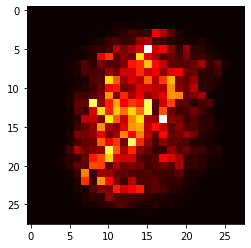

In [36]:
importance_img = forest_clf.feature_importances_.reshape((28, 28))
plt.imshow(importance_img, cmap=plt.cm.hot)

## Boosting

* 약한 학습기 여러개를 순차적으로(sequentially) 연결해서 강한 학습기를 만드는 방법.
* 단점: 훈련을 병렬적으로 시킬 수가 없어서 시간이 오래 걸릴 수 있고, 확장성(scalability)이 떨어짐.
* (비교) Voting, Bagging: 훈련을 병렬적으로 시킴.

1. AdaBoost(Adaptive Boosting): 이전 학습에서 underfit(과소적합)된 샘플들에게 높은 가중치를 눠서 다음 학습에서 사용하는 방법.
2. Gradient Boost: 이전 학습에서 발생한 오차(residual error)를 다음 훈련에서 학습시키는 방법.

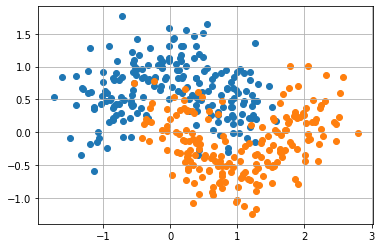

In [38]:
# 샘플 데이터
X, y = make_moons(n_samples=500, noise=0.3, random_state=42)
# train/test 분리
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

# 훈련 셋 시각화
for cls in np.unique(y_train):
    plt.scatter(X_train[y_train == cls, 0], X_train[y_train == cls, 1])
plt.grid()

## AdaBoost

In [39]:
from sklearn.ensemble import AdaBoostClassifier

In [52]:
ada_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                             n_estimators=50,      # 예측기의 개수(= 훈련 횟수)
                             learning_rate=1.0,    # 학습률  (0.1, 0.2, 0.3, 0.5, 1.0)
                             algorithm='SAMME.R',  # underfit된 샘플들에게 가중치를 주는 알고리즘.
                             random_state=42)

In [53]:
ada_clf.fit(X_train, y_train)  # 모델 훈련

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [54]:
# 학습 셋의 예측 결과
y_train_pred = ada_clf.predict(X_train)
# 학습 셋 평가
train_acc = accuracy_score(y_train, y_train_pred)
train_acc

0.965

In [55]:
# 테스트 셋의 예측 결과
y_test_pred = ada_clf.predict(X_test)
# 테스트 셋 평가
test_acc = accuracy_score(y_test, y_test_pred)
test_acc

0.88

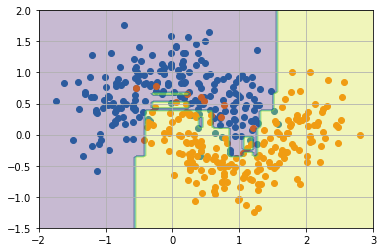

In [56]:
# 훈련 데이터 시각화
for cls in np.unique(y_train):
    plt.scatter(X_train[y_train == cls, 0], X_train[y_train == cls, 1])

# 훈련 셋의 예측 결과(결정 경계면)을 시각화
x_pts = np.linspace(start=-2, stop=3, num=100)      # (100,)
y_pts = np.linspace(start=-1.5, stop=2.0, num=100)  # (100,)
Xs, Ys = np.meshgrid(x_pts, y_pts)                  # (100, 100)
X_new = np.c_[Xs.ravel(), Ys.ravel()]               # (100*100, 2)
y_new = ada_clf.predict(X_new).reshape(Xs.shape)    # (100*100,) --reshape--> (100, 100)
plt.contourf(Xs, Ys, y_new, alpha=0.3)

plt.grid()

## GradientBoost

In [57]:
# 가상의 샘플 데이터 생성
np.random.seed(42)
m = 100  # 샘플 개수
X = np.random.rand(m, 1) - 0.5  # (100, 1) shape의 -0.5 <= X < 0.5 사이의 난수
y = (3 * X**2 + 0.05 * np.random.randn(m, 1)).ravel()  # (100,) shape의 1d array

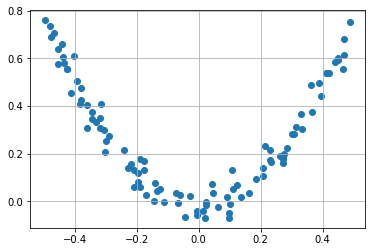

In [58]:
plt.scatter(X, y)
plt.grid()

In [59]:
from sklearn.tree import DecisionTreeRegressor

In [60]:
tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [64]:
def plot_data_predcition(regressors, X, y):
    # 데이터 시각화
    plt.scatter(X, y)
    # 예측값 시각화
    X_new = np.linspace(-0.5, 0.5, 100).reshape((100, 1))
    y_new = sum(reg.predict(X_new) for reg in regressors)
    plt.plot(X_new, y_new, 'r-')

    plt.grid()

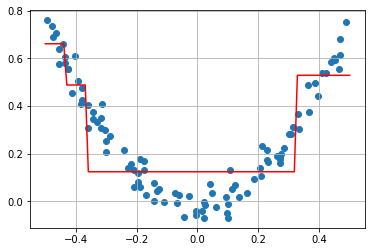

In [65]:
plot_data_predcition([tree_reg1], X, y)

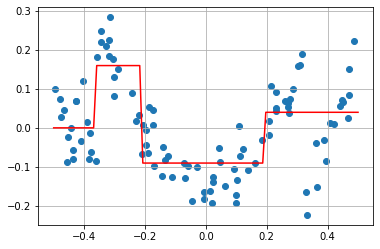

In [67]:
# 첫번째 예측기의 residual errors를 계산
y2 = y - tree_reg1.predict(X)

# residual errors를 학습할 예측기 생성
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2.fit(X, y2)

# 두번째 예측기의 예측값 시각화
plot_data_predcition([tree_reg2], X, y2)

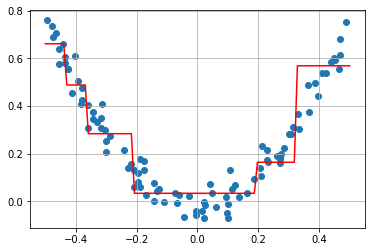

In [68]:
# 첫번째 예측기와 두번째 예측기의 예측 결과를 더하기
plot_data_predcition([tree_reg1, tree_reg2], X, y)

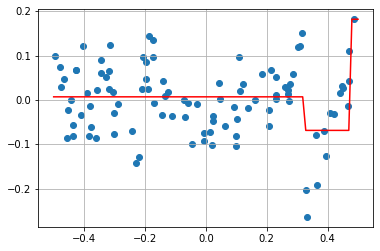

In [69]:
y3 = y2 - tree_reg2.predict(X)

tree_reg3 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg3.fit(X, y3)

plot_data_predcition([tree_reg3], X, y3)

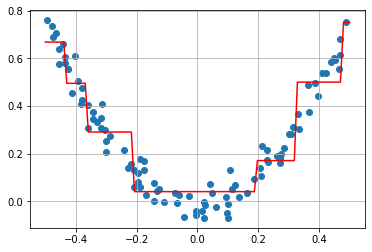

In [70]:
plot_data_predcition([tree_reg1, tree_reg2, tree_reg3], X, y)

## GBRT(Gradient Boosted Regression Tree)

In [71]:
from sklearn.ensemble import GradientBoostingRegressor

In [82]:
gbr = GradientBoostingRegressor(max_depth=2,
                                n_estimators=100,     # [10, 100, 1000]
                                learning_rate=0.1,  # [0.1, 0.2, 0.3, ...]
                                random_state=42)

gbr.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

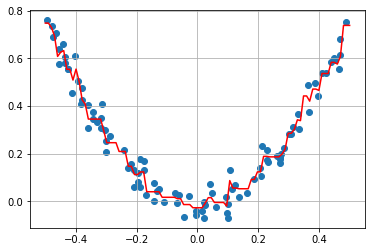

In [83]:
plot_data_predcition([gbr], X, y)

GBRT를 사용할 때, n_estimators와 learning_rate는 서로 트레이드-오프 관계
* 학습률(learning_rate)이 작으면, 앙상블 학습에 사용되는 Tree 개수(n_estimators)가 커져야 성능이 좋아짐.
* 학습률이 커지면, 학습에 사용되는 tree 개수가 작아도 비슷한 성능을 보임.
* GridSearchCV을 사용해서 하이퍼 파라미터 튜닝!

In [84]:
# XGBoost(Extreme Gradient Boost): 매우 빠른 속도와 조기 종료(early stopping)을 구현한 Gradient Boosting.
import xgboost  # scikit-learn 모듈이 아님!

In [85]:
xgb_reg = xgboost.XGBRegressor(random_state=42)
xgb_reg.fit(X, y)

[03:17:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

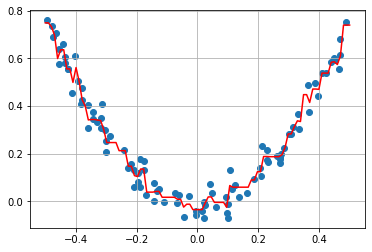

In [86]:
plot_data_predcition([xgb_reg], X, y)